In [1]:
from vnstock import *
import numpy as np
from datetime import datetime 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
from pyti.exponential_moving_average import exponential_moving_average as ema

In [2]:
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt.efficient_frontier import EfficientFrontier

In [3]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from tensorboard.plugins.hparams import api as hp

In [4]:
df=pd.read_csv("../resources/indexProcessed.csv",parse_dates=['Date'])
df.head()

,Index,Date,Open,High,Low,Close,Adj Close,Volume,CloseUSD
0,HSI,1986-12-31,2568.300049,2568.300049,2568.300049,2568.300049,2568.300049,0.0,333.879006
1,HSI,1987-01-02,2540.100098,2540.100098,2540.100098,2540.100098,2540.100098,0.0,330.213013
2,HSI,1987-01-05,2552.399902,2552.399902,2552.399902,2552.399902,2552.399902,0.0,331.811987
3,HSI,1987-01-06,2583.899902,2583.899902,2583.899902,2583.899902,2583.899902,0.0,335.906987
4,HSI,1987-01-07,2607.100098,2607.100098,2607.100098,2607.100098,2607.100098,0.0,338.923013


In [5]:
df_N225= df.loc[df.Index == 'N225',['Date','CloseUSD']]
df_N225.set_index('Date',inplace=True)
df_N225

,CloseUSD
Date,
1965-01-05,12.577200
1965-01-06,12.639900
1965-01-07,12.742700
1965-01-08,12.864301
1965-01-12,12.885400
...,...
2021-05-28,291.494102
2021-05-31,288.600801
2021-06-01,288.143398


Text(0.5, 1.0, 'price stock')

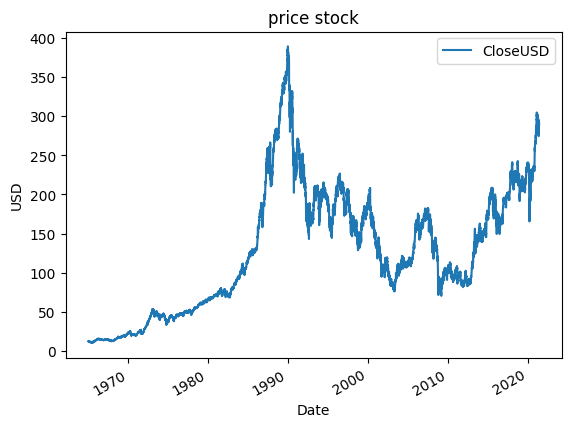

In [6]:
df_N225.plot()
plt.ylabel("USD")
plt.title("price stock")

Used to grow rapidly, but then it declined and is slowly coming back

Text(0.5, 1.0, 'stock change')

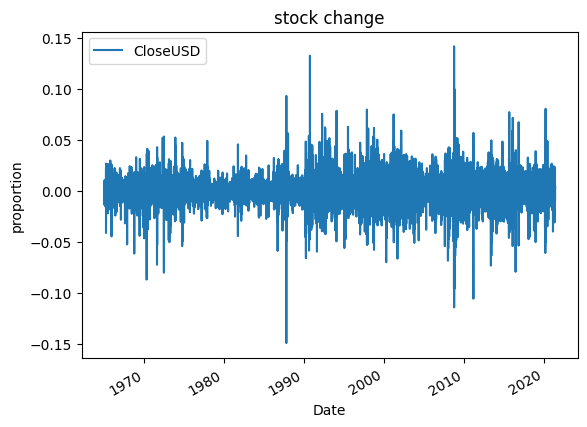

In [7]:
df_N225.pct_change().plot()
plt.ylabel("proportion")
plt.title("stock change")

financial crisis in 2008 is the one of the problems cause stock changes

Text(0.5, 1.0, 'ACCRUED INTEREST')

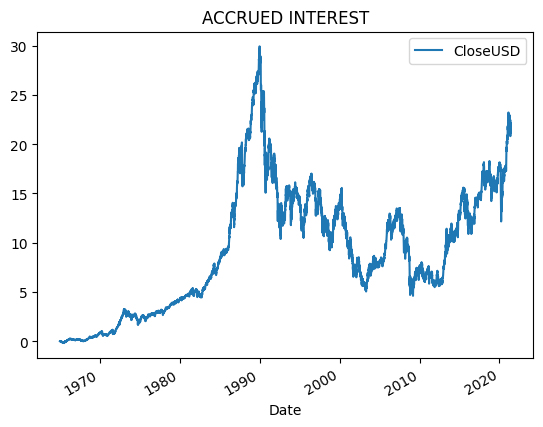

In [8]:
n= df_N225.pct_change().dropna()
a= (n+1)
cumprod = a.cumprod().sub(1)
cumprod.plot()
plt.title("ACCRUED INTEREST")

To date, the stock price has increased nearly 25 times from the original

RISK AND RETURN

<AxesSubplot: xlabel='Date'>

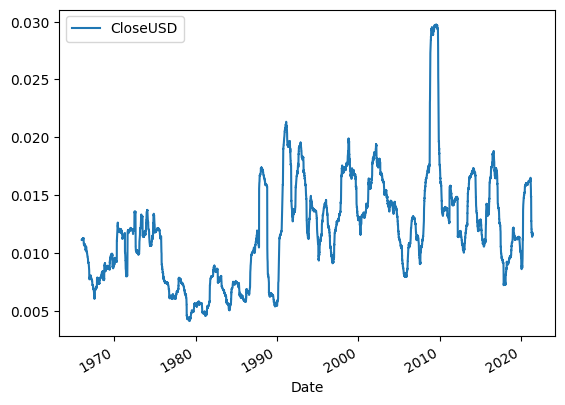

In [9]:
volatility=n.rolling(246).std()
volatility.plot()

Volatility Strong

In [10]:
#tính sharpe ratio
month_return = (((cumprod.iloc[-1]+1)**(246/len(n)))-1)
sharpe_ratio = month_return/(n.std()*np.sqrt(246))
sharpe_ratio.values

array([0.28710989])

Sharpe ratio >0 (okey)

In [11]:
#tính VaR(value at Risk) giá trị ở rủi ro
'''
boot_distn = []
np.random.seed(42)
for i in range(5000):
    a=np.mean(
        df_N225['CloseUSD'].sample(frac=1,replace=True)
    )
    boot_distn.append(a)
std_error = np.std(boot_distn,ddof=1)
mean_boot_distn = np.mean(boot_distn)
z_score = (mean_boot_distn-df_N225['CloseUSD'].mean())/(std_error)
VaR= abs(z_score)*df_N225['CloseUSD'][-1]*df_N225['CloseUSD'].std()
VaR
'''

"\nboot_distn = []\nnp.random.seed(42)\nfor i in range(5000):\n    a=np.mean(\n        df_N225['CloseUSD'].sample(frac=1,replace=True)\n    )\n    boot_distn.append(a)\nstd_error = np.std(boot_distn,ddof=1)\nmean_boot_distn = np.mean(boot_distn)\nz_score = (mean_boot_distn-df_N225['CloseUSD'].mean())/(std_error)\nVaR= abs(z_score)*df_N225['CloseUSD'][-1]*df_N225['CloseUSD'].std()\nVaR\n"

In [12]:
VaR = (1.65*df_N225['CloseUSD'].std())
VaR

132.4368660997881

maximum amount you can lose in given time with 95% confidence level

LSTM

In [13]:
training_set = df_N225['CloseUSD'][:-246].values.reshape(-1,1)
test_set = df_N225["CloseUSD"][len(training_set)-len(df_N225)-246:].values.reshape(-1,1)
print(len(training_set),len(test_set))

13628 492


In [14]:
# Thuc hien scale du lieu gia ve khoang 0,1
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)
test_set_scaled = sc.fit_transform(test_set)
print(len(training_set_scaled))
print(len(test_set_scaled))

13628
492


In [15]:
# Tao du lieu train, X = 246 time steps, Y =  1 time step
X_train = []
y_train = []
no_of_sample = len(training_set)

for i in range(246, no_of_sample):
    X_train.append(training_set_scaled[i-246:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape

(13382, 246, 1)

In [16]:
# Tao du lieu test, x=22,y=1
X_test = []
Y_test = []
no_of_sample = len(test_set)

for i in range(246, no_of_sample):
    X_test.append(test_set_scaled[i-246:i, 0])
    Y_test.append(test_set_scaled[i, 0])
X_test, Y_test = np.array(X_test), np.array(Y_test)

X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
X_test.shape

(246, 246, 1)

In [17]:
def create_model(units,dropout_rate,activation,optimizer,epochs):
    # Xay dung model LSTM
    regressor = Sequential()
    regressor.add(LSTM(units = units, return_sequences = True, input_shape = (246, 1) ))
    regressor.add(Dropout(dropout_rate))
    for i in range(epochs):
        regressor.add(LSTM(units = units, return_sequences = True))
        regressor.add(Dropout(dropout_rate))
    regressor.add(LSTM(units = units/2))
    regressor.add(Dropout(dropout_rate))
    regressor.add(Dense(units = 1,activation=activation))
    regressor.compile(optimizer = optimizer, loss = 'mean_squared_error')
    return regressor


In [19]:
model = create_model(units=246,activation='tanh',dropout_rate=0.3,epochs=5,optimizer='Adamax')
h = model.fit(x=X_train, y=y_train, epochs = 5,batch_size=41,verbose=1)

Epoch 1/5
327/327 [==============================] - 1142s 3s/step - loss: 0.0037
Epoch 2/5
327/327 [==============================] - 1042s 3s/step - loss: 0.0010
Epoch 3/5
327/327 [==============================] - 1033s 3s/step - loss: 8.3352e-04
Epoch 4/5
327/327 [==============================] - 1043s 3s/step - loss: 8.0551e-04
Epoch 5/5
327/327 [==============================] - 1078s 3s/step - loss: 7.5652e-04


In [20]:
prediction = model.predict(X_test)

8/8 [==============================] - 10s 618ms/step


In [21]:
from sklearn.metrics import mean_absolute_percentage_error
MAPE = mean_absolute_percentage_error(Y_test, prediction)
Accuracy = 1 - MAPE
Accuracy

0.9230162582804622

Accuracy 92%